[View in Colaboratory](https://colab.research.google.com/github/akxkcd/fattails/blob/master/ekf.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

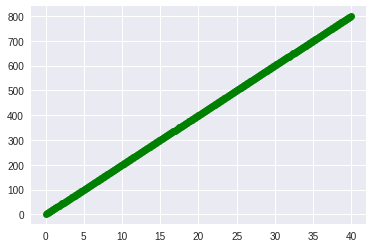

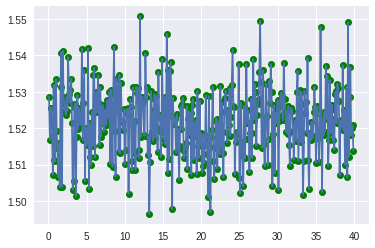

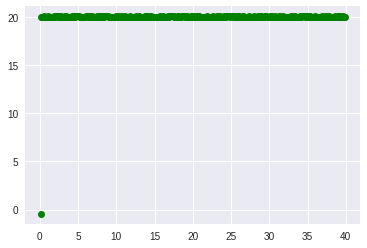

In [232]:
time_list = []
measurement_list = []
num_data = 400
dt = 0.1
last_x = 1
last_y = 2
for i in range(1, num_data):
  noise = [np.random.normal(0, .1), np.random.normal(0, 0.01), np.random.normal(0, 0.01)]
  time_list.append(i*dt)
  x = i*dt
  y = 20*i*dt
  r = np.sqrt(x*x + y*y)
  azimuth = math.atan(y/x)
  v = np.sqrt((x-last_x)**2 + (y-last_y)**2)/dt
  v_x = (x-last_x)/dt
  v_y = (y-last_y)/dt
  # rr = (v)*math.cos(azimuth)
  rr = (x*v_x + y*v_y)/np.sqrt(x**2 + y**2)
  measurement_list.append(np.array([r, azimuth, rr]) + noise)
  # print(v, v_x, v_y)
  
  last_x = x
  last_y = y

  
measurement_list = np.array(measurement_list)
plt.plot(time_list, measurement_list[:, 0], 'go')
plt.show()
plt.plot(time_list, measurement_list[:, 1], 'go')
plt.plot(time_list, measurement_list[:, 1])
plt.show()
plt.plot(time_list, measurement_list[:, 2], 'go')
plt.show()

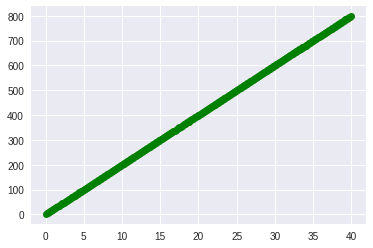

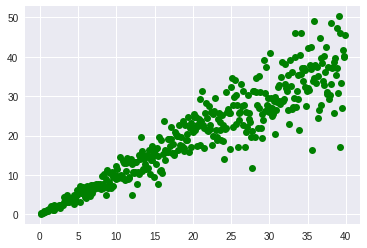

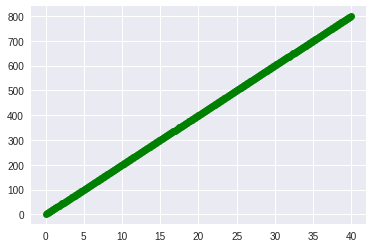

In [233]:
x_list = []
y_list = []
for m in measurement_list:
  y = m[0]*np.sin(m[1])
  x = m[0]*np.cos(m[1])
  x_list.append(x)
  y_list.append(y)
  # print(m[0], x, y)
plt.plot(time_list, y_list, 'go')
plt.show()
plt.plot(time_list, x_list, 'go')
plt.show()
plt.plot(time_list, measurement_list[:, 0], 'go')
plt.show()

In [0]:
class kalman_filter():
  
  def __init__(self):
    self.state = np.array([0., 0.]).T
    self.P = np.array([[1., 0.], [0., 1.]])
    self.last_time = 0.
    self.R = np.array([0.01])
    self.Q = np.array([[.01, 0.], [0., .01]])
    self.state_history = []
    self.P_history = []
    self.state_pre_history = []
    self.P_pre_history = []
    self.time_history = []
    self.measurement_list = []
    
  def update_time(self, cur_time):
    delta_t = cur_time - self.last_time
    self.last_time = cur_time
    
    F = np.array([[1., delta_t], [0., 1.]])
    self.state = np.dot(F, self.state)
    self.P = np.dot(np.dot(F, self.P), F.T) + self.Q
    self.time_history.append(cur_time)
    self.state_pre_history.append(self.state)
    self.P_pre_history.append(self.P)
  
  def show(self):
    print("state:", self.state)
    print("P:", self.P)
    
  def update_measurement(self, measurement, display=False):
    H = np.array([1., 0.])
    # innovation
    y_k = measurement - np.dot(H, self.state)
    if display:
      print("y_k", y_k)
    
    # innovation covariance
    S_k = self.R + np.dot(np.dot(H, self.P), H.T)
    if display:
      print("S_k:", S_k)
    
    # kalman gain
    K_k = np.dot(self.P, H.T)/S_k
    if display:
      print("K_k:", K_k)
      
    # updated state
    self.state_delta = np.dot(K_k, y_k)
    self.state = self.state + self.state_delta
    if display:
      print("updated state:", self.state)
      
    # updated covariance
    K_dot_H = 1 - np.dot(K_k, H)
    self.P = np.dot(np.dot(K_dot_H, self.P), K_dot_H.T) + \
      np.dot(K_k, K_k.T)*self.R
    if display:
      print("updated covariance:", self.P)
    
    # measurement post-fit
    y_k = measurement - np.dot(H, self.state)
    # print(y_k)
    self.measurement_list(self.state)
    self.state_history.append(self.state)
    self.P_history.append(self.P)
    

In [0]:
class extended_kalman_filter():
  
  def __init__(self):
    self.state = np.zeros((4,1)) + 0.1
    self.state = np.array([1, 2, 0., 0.])
    self.state = np.reshape(self.state, (4,1))
    self.P = np.eye(4)*1
    self.last_time = 0.
    self.R = np.ones((3, 1))*.1
    self.Q = np.eye(4) * 0.01
    self.state_history = []
    self.P_history = []
    self.state_pre_history = []
    self.P_pre_history = []
    self.time_history = []
    self.measurement_history = []
    
  def F(self, delta_time):
    mat = np.array([[1., 0., delta_time, 0.], [0., 1., 0., delta_time],\
                    [0., 0., 1., 0.], [0., 0., 0., 1.]])
    return mat
  
  def H(self, state_vector, display=False):
    p_x = state_vector.item(0)
    p_y = state_vector.item(1)
    v_x = state_vector.item(2)
    v_y = state_vector.item(3)
    
    a = p_x*p_x + p_y*p_y
    mat = np.array([[p_x/np.sqrt(a), p_y/np.sqrt(a), 0., 0.], 
                    [-p_y/(a), p_x/(a), 0., 0.], 
                    [p_y*(v_x*p_y-v_y*p_x)/(np.power(a, 1.5)), p_x*(v_y*p_x-v_x*p_y)/(np.power(a, 1.5)), p_x/np.sqrt(a), p_y/np.sqrt(a)]])
    if display:
      print("a:", a)
      print("H:", mat)
    return mat
  
  def h_x(self, state_vector, display=False):
    x = state_vector.item(0)
    y = state_vector.item(1)
    r = np.sqrt(x*x + y*y)
    azimuth = math.atan(y/x)
    v_x = state_vector.item(2)
    v_y = state_vector.item(3)
    rr = (x*v_x + y*v_y)/np.sqrt(x**2 + y**2)
    mat = np.reshape([r, azimuth, rr], (3,1))
    return mat

  def update_time(self, cur_time):
    delta_t = cur_time - self.last_time
    self.last_time = cur_time
    
    F = self.F(delta_t)
    self.state = np.dot(F, self.state)
    self.P = np.dot(np.dot(F, self.P), F.T) + self.Q
    self.time_history.append(cur_time)
    self.state_pre_history.append(self.state)
    self.P_pre_history.append(self.P)
  
  def show(self):
    print("state:", self.state.shape)
    print("P:", self.P)
    
  def update_measurement(self, measurement, display=False):
    H = self.H(self.state, display)
    
    # innovation
    y_k = measurement - self.h_x(self.state)
    if display:
      print("measurement:", measurement)
      print("y_k", y_k)
    
    # innovation covariance
    S_k = self.R + np.matmul(np.matmul(H, self.P), H.T)
    if display:
      print("S_k:", S_k)
    
    # kalman gain
    K_k = np.matmul(np.matmul(self.P, H.T), np.linalg.inv(S_k))
    if display:
      print("K_k:", K_k)
      
    # updated state
    self.state_delta = np.dot(K_k, y_k)
    self.state = self.state + self.state_delta
    if display:
      print("state_delta:", self.state_delta)
      print("updated state:", self.state)
      
    # updated covariance
    K_dot_H = 1 - np.matmul(K_k, H)
    self.P = self.P - np.matmul(np.matmul(K_k, S_k), K_k.T)
    if display:
      print("K_dot_H:", K_dot_H)
      print("updated covariance:", self.P)
    
    self.state_history.append(self.state)
    self.P_history.append(self.P)
    self.measurement_history.append(measurement)
    

In [236]:
filter = extended_kalman_filter()

for t, d in zip(time_list, measurement_list):
  # print(t, d)
  filter.update_time(t)
  # filter.show()
  filter.update_measurement(np.reshape(d, (3,1)), False)

states = np.array(filter.state_history)
print(states.shape)
states = np.reshape(states, (states.shape[0], states.shape[1]))
print(states.shape)

(399, 4, 1)
(399, 4)


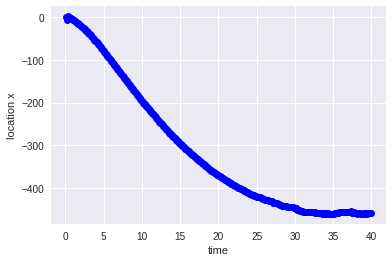

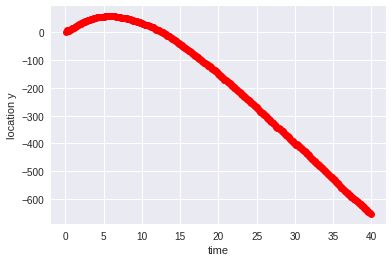

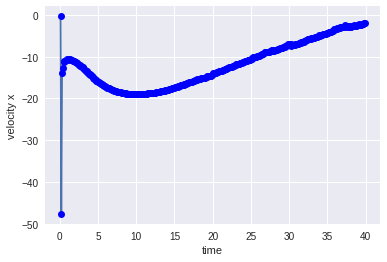

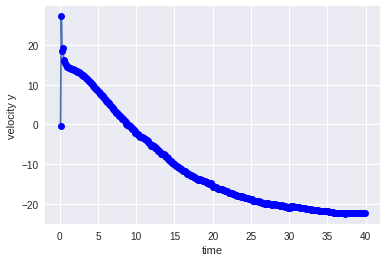

In [237]:
plt.plot(time_list, states[:, 0])
plt.plot(time_list, states[:, 0], 'bo')
plt.ylabel("location x")
plt.xlabel("time")
plt.show()
plt.ylabel("location y")
plt.xlabel("time")
plt.plot(time_list, states[:, 1], 'ro')
plt.show()

plt.plot(time_list, states[:, 2])
plt.plot(time_list, states[:, 2], 'bo')
plt.ylabel("velocity x")
plt.xlabel("time")
plt.show()

plt.plot(time_list, states[:, 3])
plt.plot(time_list, states[:, 3], 'bo')
plt.ylabel("velocity y")
plt.xlabel("time")
plt.show()
# plt.plot(time_list, measurement_list, 'go')

(399, 1)


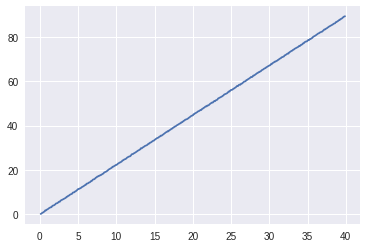

In [230]:
measurements = np.array(filter.measurement_history)
print(measurements[:,0].shape)
plt.plot(filter.time_history, measurements[:, 0])

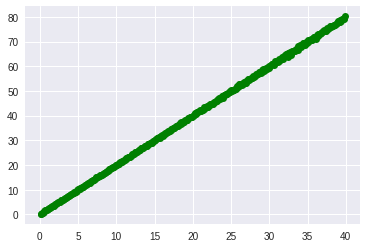

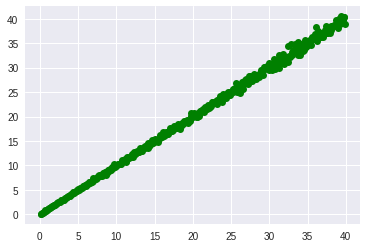

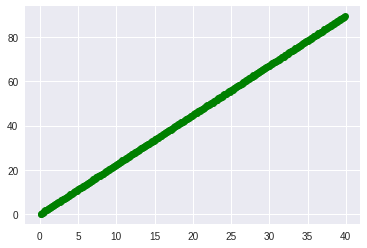

In [231]:
x_list = []
y_list = []
for m in measurement_list:
  y = m[0]*np.sin(m[1])
  x = m[0]*np.cos(m[1])
  x_list.append(x)
  y_list.append(y)
  # print(m[0], x, y)
plt.plot(time_list, y_list, 'go')
plt.show()
plt.plot(time_list, x_list, 'go')
plt.show()
plt.plot(time_list, measurement_list[:, 0], 'go')
plt.show()